# Behavior Cloning Project December 31, 2017

*The goals / steps of this project are the following:*
* Use the simulator to collect data of good driving behavior
* Build, a convolution neural network in Keras that predicts steering angles from images
* Train and validate the model with a training and validation set
* Test that the model successfully drives around track one without leaving the road
* Summarize the results with a written report

**Helper Function to Pre-process Data**

*To preprocess the data, I firstly read data as RGB, and then went through the following steps:*

*- Brightness adjustment: The car was not performing well where there are shadows on the track, and therefore I adjusted the brightness of the image to capture it.*

*- Capturing left, center and right cameras: Since most of the data only captures correct driving, when the car is drifting away from the center, the car will not know where to steer. Therefore, I randomly choose between left, center and right cameras to capture side pictures. In addition, a correction angle is added for the steering angle of the left images and dedeucted deducted for the right images.*

*- Flip images: Since the training data are all recorded by driving counter-clockwise, which mostly involves left turns, the model could not generalize well. Thus, I randomly flipped 75% of the images, and assigned a opposite sign of the steering measure to simulate driving in the opposite direction so the model can better generalize.*

*- Zero Bias Adjustment: Since most of the training data has steering angle of zero, the model will tend to drive straight ahead, and get stuck easily. In order to correct the bias towards zero, I added a random threshold so that the steering measures with angles below the threshold will be excluded.*

In [225]:
import csv
import cv2
import numpy as np
from scipy.misc import imread

### helper function to adjust brightness
def augmentbrightness(image):
    temp = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    #Compute a random brightness value and apply to the image
    brightness = 0.5 + np.random.uniform()
    temp[:,:,2] = temp[:,:,2] * brightness
    temp[:,:,2][temp[:,:,2]>225] = 225
    return cv2.cvtColor(temp, cv2.COLOR_HSV2RGB)

### read data    
def readdata(dircsv, dirimage):
    lines = []
    with open(dircsv) as csvfile:
        reader = csv.reader(csvfile)
        next(reader,None)
        for line in reader:
            lines.append(line)
    
    images = []
    measurements = []
    for line in lines:
        img_choice = np.random.randint(3)
        
        #randomly discard image with angle below a threshold
        threshold = np.random.uniform(low=0,high=0.01)
        if abs(float(line[3])) > threshold:
            #Randomly choose between left, center and right images
            source_path = line[img_choice]
            filename = source_path.split('/')[-1]
            current_path = dirimage +filename
            #print(current_path)
            image = imread(current_path)
        
            if img_choice==0: #center camera
                correction = 0
            elif img_choice == 1: #left camera
                 correction = 0.2 
            elif img_choice==2: #right camera
                correction = -0.2

            #print(i,filename, correction)
            measurement = float(line[3]) + correction
        
            #adjust brightness
            images.append(augmentbrightness(image))
            measurements.append(measurement)
 
            #flip image: randomly flip 75% of the images
            if np.random.randint(4) < 3:
                images.append(cv2.flip(image,1))
                measurements.append(measurement*-1.0)
               
    return (images, measurements)

**Collect and Load Data**

*I started with the Udacity data, but the data mainly captures normal driving. In order to better train the model, I used the simulator to capture more data:*

*- 2 laps of normal driving to expand the training data*

*- 1 lap of weaving driving: when the car drifts away from the center, it needs to know how to recover back to center. Therefore, I added some data of weaving driving.*

*- 1 lap of revsered lap: I drove the simulator clockwise to generalize. However, due to bad driving skills, this dataset did not help much and I excluded it from the final training set.*

*- 2 times weaving cross the bridge and the big left turn after bridge: the model performs badly at the bridge since the bridge edge is straight, and the old data tends to set steering angle to zero on the bridge. When the car enters the bridge at an angle, it gets stuck. Also, the car easily get stuck at the big left turn after the bridge. Therefore I collected extra data for those sections and the model performs well on those sections. *

*- 4 times the big right turn - since the counter-clockwise lap mainly consists of left turns, the steering measures are skewed to negative angles, and the model performs badly at the big right turn towards the end of the lap. Also, the right turn is really sharp and requires a very big angle, while most of the training data have smaller angles. In order to perform better on that section, I added 8 times of the right turn section to the training data. This corrects the skewness of the angle distributions.*

In [255]:
X1, Y1 = readdata('data1/driving_log.csv', 'data1/IMG/')
X2, Y2 = readdata('data2/driving_log.csv', 'data2/IMG/') #2x normal driving
X3, Y3 = readdata('data3/driving_log.csv', 'data3/IMG/') #1x weaving driving
X4, Y4 = readdata('data4/driving_log.csv', 'data4/IMG/') #1x reversed lap
X5, Y5 = readdata('data5/driving_log.csv', 'data5/IMG/') #2x Bridge and the big left turn after bridge
X6, Y6 = readdata('data6/driving_log.csv', 'data6/IMG/') #1 Right turn
X7, Y7 = readdata('data7/driving_log.csv', 'data7/IMG/') #3 Right turn
X8, Y8 = readdata('data8/driving_log.csv', 'data8/IMG/') #3 Right turn
X9, Y9 = readdata('data9/driving_log.csv', 'data9/IMG/') #1 Right turn
X10, Y10 = readdata('data10/driving_log.csv', 'data10/IMG/') #1 end part
print(np.array(X1).shape,  np.array(Y1).shape)
print(np.array(X2).shape,  np.array(Y2).shape)
print(np.array(X3).shape,  np.array(Y3).shape)
print(np.array(X4).shape,  np.array(Y4).shape)
print(np.array(X5).shape,  np.array(Y5).shape)
print(np.array(X6).shape,  np.array(Y6).shape)
print(np.array(X7).shape,  np.array(Y7).shape)
print(np.array(X8).shape,  np.array(Y8).shape)
print(np.array(X9).shape,  np.array(Y9).shape)
print(np.array(X10).shape,  np.array(Y10).shape)

# import zipfile
# import os
# outdir = str(os.path.abspath('.'))
# zip_ref = zipfile.ZipFile('data.zip', 'r')
# zip_ref.extractall(outdir)
# zip_ref.close()

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:38: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


(6322, 160, 320, 3) (6322,)
(1042, 160, 320, 3) (1042,)
(962, 160, 320, 3) (962,)
(860, 160, 320, 3) (860,)
(775, 160, 320, 3) (775,)
(150, 160, 320, 3) (150,)
(440, 160, 320, 3) (440,)
(593, 160, 320, 3) (593,)
(183, 160, 320, 3) (183,)
(319, 160, 320, 3) (319,)


*Concatenate all the data: Note that I have excluded some weaving driving data on the bridges, because too much weaving driving will cause the car to oscilate a lot.*

In [257]:
X_train = []
y_train = []
X_train = np.concatenate((X1,X2,X3,X5[300:],X6,X7,X8,X9,X10), axis=0)
X_train = np.array(X_train)
y_train = np.concatenate((Y1,Y2,Y3,Y5[300:],Y6,Y7,Y8,Y9,Y10), axis=0)
y_train = np.array(y_train)
print(X_train.shape, y_train.shape)

(10486, 160, 320, 3) (10486,)


*Here I visualized some training data, and demonstrated some recover images.*

X1- Normal Driving


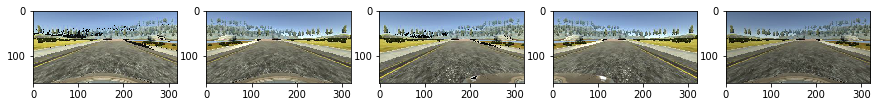

X5- Weaving on bridges


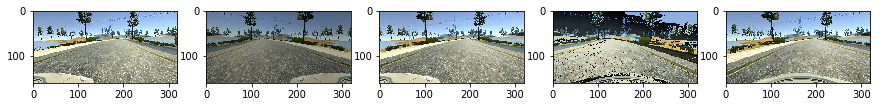

X9- Sharp Right Turn


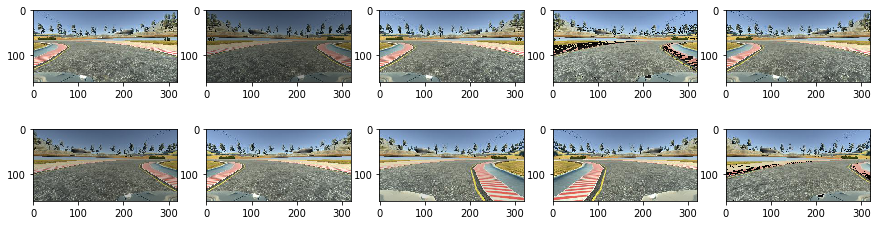

In [317]:
import matplotlib.pyplot as plt
#print a color image
def printimage(image):
#     image = image.squeeze()
#     plt.figure(figsize=(4,4))
#     plt.imshow(image)
#     plt.show()
    numPerRow = 5
    numImages = image.shape[0]
    numofRows = np.int(np.ceil(numImages/numPerRow))
    fig = plt.figure(figsize=(numPerRow*3,numofRows*4))
    for i in range (numImages):
        img = image[i,:,:,:].squeeze()
        ax = fig.add_subplot(np.int(np.ceil((i+1)/numPerRow)),numPerRow,i+1) 
        ax.imshow(img)
    plt.show()

print("X1- Normal Driving")
printimage(np.array(X1[0:5]))
print("X5- Weaving on bridges")
printimage(np.array(X5[5:10]))
print("X9- Sharp Right Turn")
printimage(np.array(X9[25:35]))

** Steering Measurement Distributions**

*After the correction for skewness, the data is normally distributed, with slight punishments to for 0 angles. * 

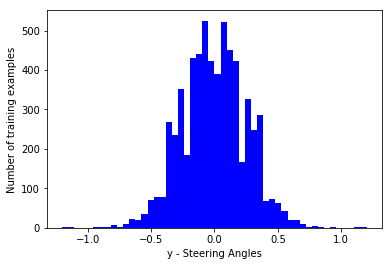

In [264]:
#check measurements distributions for zero bias
plt.hist(Y1, bins =50,color='b')
plt.xlabel("y - Steering Angles")
plt.ylabel("Number of training examples")
plt.show()

*** Model Training***

*Data Normalization and Cropping: I first normalized the image data to be between -0.5 and 0.5. Then I chopped out the upper and lower part of the images, which mainly consists of sky and the hood of the car, and do not help the training process.*

*Regularization- I applied 20% dropout on the fuly connected layers to avoid overfitting.*

*Optimizer- I used Adam optimizer to minimize the mean square error of the prediction loss.*

*Train/Valid split- I splitted 20% of training data as validation data. No test data is needed because running the model in the simulator is equivalent to testing the model.*

*Epoch- The validatio loss starts to increase after epoch 7, which is a sign of overfitting. Therefore, I stopped at epoch 7 for training the model.*

*Generator- I did not use generator because the code runs pretty fast already, and the current structure is more convinent for adding/excluding extra training data.*

*Model Structure- I constructed the model based on the NVIDIA Architecture:*

Layer Number|Layer Name|Output Size|Description|Activation|Dopout
----|-----|---
0|Input|160x320x3 |na|na|na
0.1|Normalization|160x320x3 |na|na|na
0.2|Cropping|90x320x3 |na|na|na
1|Convolution1 | 43x158x24| 5x5 kernal, stride = 2, 24 filters|Relu|na
2|Convolution2 | 20x77x36| 5x5 kernal, stride = 2, 36 filters|Relu|na
3|Convolution3 | 8x37x48  | 5x5 kernal, stride = 2, 48 filters|Relu|na
4|Convolution4 | 6x35x64  | 3x3 kernal, stride = 1, 64 filters|Relu|na
5|Convolution5 | 4x33x64  | 3x3 kernal, stride = 1, 64 filters|Relu|na
na|flatten|8448 inputs|na|na|na
7|fully connected1 |100 neurons|Relu|na|0.2
8|fully connected2 |50 neurons|Relu|na|0.2
9|fully connected3 |10 neurons|Relu|na|0.2
10|Output|predicted steering angles|na|na|na


In [318]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Reshape
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras import backend as K
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint

model = Sequential()
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(160,320,3))) #normalize data
model.add(Cropping2D(cropping=((50,20), (0,0))))
#model.add(Lambda(lambda x: K.tf.image.resize_images(x, (64, 64)))) #resize to 64x64 to expedite training
model.add(Convolution2D(24,5,5,subsample = (2,2), activation = "relu"))
model.add(Convolution2D(36,5,5,subsample = (2,2), activation = "relu"))
model.add(Convolution2D(48,5,5,subsample = (2,2), activation = "relu"))
model.add(Convolution2D(64,3,3,subsample = (1,1), activation = "relu"))
model.add(Convolution2D(64,3,3,subsample = (1,1), activation = "relu"))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
###Relu
# model.add(Convolution2D(6,5,5,activation = "relu"))
# model.add(MaxPooling2D())
# model.add(Convolution2D(6,5,5,activation = "relu"))
# model.add(MaxPooling2D())
# model.add(Flatten())
# model.add(Dense(120))
# model.add(Dense(84))
# model.add(Dense(1))

model.compile(loss='mse', optimizer = 'adam')
filepath = 'weighs-improvement-{epoch:02d}-{val_loss:.2f}.h5'
checkpoint=ModelCheckpoint(filepath,monitor="val_loss",verbose=1,save_best_only=True, mode='min')
callbacks_list = [checkpoint]
model.fit(X_train, y_train, validation_split = 0.2,shuffle=True, nb_epoch =6,batch_size =128, callbacks=callbacks_list, verbose=1)

model.save('model.h5')


Train on 8388 samples, validate on 2098 samples
Epoch 1/6
8388/8388 [==============================] - 63s - loss: 0.0614 - val_loss: 0.0896
Epoch 2/6
8388/8388 [==============================] - 60s - loss: 0.0432 - val_loss: 0.0694
Epoch 3/6
8388/8388 [==============================] - 60s - loss: 0.0402 - val_loss: 0.0709
Epoch 4/6
8388/8388 [==============================] - 60s - loss: 0.0374 - val_loss: 0.0685
Epoch 5/6
8388/8388 [==============================] - 61s - loss: 0.0356 - val_loss: 0.0668
Epoch 6/6
8388/8388 [==============================] - 60s - loss: 0.0344 - val_loss: 0.0631


*print model specifications and number of parameters*

In [269]:
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_75 (Lambda)               (None, 160, 320, 3)   0           lambda_input_41[0][0]            
____________________________________________________________________________________________________
cropping2d_41 (Cropping2D)       (None, 90, 320, 3)    0           lambda_75[0][0]                  
____________________________________________________________________________________________________
convolution2d_181 (Convolution2D (None, 43, 158, 24)   1824        cropping2d_41[0][0]              
____________________________________________________________________________________________________
convolution2d_182 (Convolution2D (None, 20, 77, 36)    21636       convolution2d_181[0][0]          
___________________________________________________________________________________________

*** Performance ***

*The car can run on track one smoothly without stepping on the lines.*

*** Potential Improvements ***

*1. the car seem to oscilate a bit when it is not necessary. This is caused by the addition weaving data added and the adjustment for skewness. The data pre-processing can be fine-tuned to produce more smooth driving.*

*2. the car doesn't perform well on the second track. It is because the model couldn't generalize well enough on windy mountain road with two lanes. More training data from the second track can be added to further train the model.*

*3. data augmentation can be added to better generalize the model.*

*4. different architectures can be experimented.*
